# Heat Stress
This breaks down each contribution to the theoretical scaling factor.

In [34]:
import copy
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, clausius_clapeyron_factor, sphum_sat
from isca_tools.utils.constants import kappa, L_v, c_p, g, R
from isca_tools.utils import area_weighting, annual_time_slice
from isca_tools.utils.ds_slicing import annual_mean
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.thesis.adiabat_theory import get_theory_prefactor_terms,mse_mod_anom_change_ft_expansion, mse_mod_change_surf_expansion, \
    get_scaling_factor_theory, get_temp_adiabat
from isca_tools.plot import label_subplots
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
from scipy import integrate
import numpy_indexed
from scipy.stats import percentileofscore
import copy
# Use custom matplotlib style for publishing
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
import matplotlib
# matplotlib.rcParams['lines.linewidth'] = 1.2          # make lines bigger for presentation

In [3]:
# Load dataset - at surface and in free troposphere
use_time_start = 360*2
pressure_ft = 500               # Desired approximate pressure of free troposphere (hPa)

# Load dataset
tau_lw_ref = 1
tau_lw_warm = 1.5
exp_dir = 'rossbypalooza/vary_rot_rate/'
# exp_dir = 'tau_sweep/aquaplanet/depth=1/'
# exp_dir = 'tau_sweep/aquaplanet/depth=1/ras_conv/'

# only keep variables required to compute relative humidity and MSE
var_keep = ['temp', 'sphum', 'height', 'klzbs', 'convflag', 'swdn_toa', 'olr', 't_surf', 'precipitation']

# exp_names = ['Aquaplanet', 'Constant conductivity', 'Bucket', 'Bucket - $C_V$']
# exp_dir = ['tau_sweep/aquaplanet/', 'tau_sweep/land/meridional_band/evap/', 'tau_sweep/land/meridional_band/bucket/',
#            'tau_sweep/land/meridional_band/bucket_evap/evap=0_1/']
# color_seq_exp = ['b', 'g', 'orange', 'r']
rot_rate = [1, 2]
exp_names = [str(rot_rate[0]), str(rot_rate[1])]
n_exp = len(exp_names)
ds = []
albedo = []
tau_sw = []
tau_lw = []
# time_ind_start = 0  
time_ind_start = 100
# time_ind_final = 1467       # so both experiments are of same length
time_ind_final = 9999999999999999
with tqdm(total=n_exp, position=0, leave=True) as pbar:
    for j in range(n_exp):
        ds_use = isca_tools.load_dataset(exp_dir + exp_names[j]).isel(time=slice(time_ind_start, time_ind_final))
        
        ds += [ds_use.sel(pfull=[np.inf, pressure_ft], method='nearest')[var_keep]]      # only keep the surface and free troposphere values
        namelist = isca_tools.load_namelist(exp_dir + exp_names[j])  # Need this for albedo_value
        albedo += [namelist['mixed_layer_nml']['albedo_value']]
        tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
        tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]
        pbar.update(1)
        
pfull = ds_use.pfull
ind_surf = 0
ind_ft = 1
p_surface = float(ds[0].pfull[ind_surf]) * 100
pressure_ft_actual = float(ds[0].pfull[ind_ft]) * 100       # Actual pressure of free troposphere (Pa)
n_pressure = ds[0].pfull.size

100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


In [4]:
pressure_from_level_func = scipy.interpolate.interp1d(np.arange(len(pfull)), pfull)
def lzb(k, interp_func=pressure_from_level_func):
    # Offset by -1 because fortran starts with 1, but python starts with 0
    # ds.t_ref will match exactly ds.temp if -2 used as offset, but this is not the LNB.
    if np.size(k) == 1:
        return float(interp_func(k-1))
    else:
        return interp_func(k-1)

## Get datasets
Get one dataset for summer for each $\kappa$, combining all latitudes: `ds_all`. This combines the all or just tbe summer months in each hemisphere, e.g. negative latitudes will only correspond to times in December, January or February.

In [5]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 
save_pad_inches = 0.05

# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


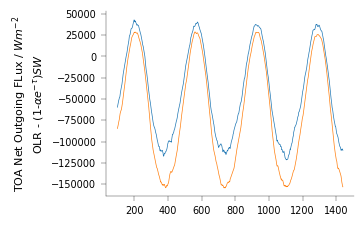

In [6]:
# Plot evolution of net flux and temperature to see how long it takes to spin up
def plot_spinup(ds_array, ax, albedo, tau, ds_name):
    for i, ds_use in enumerate(ds_array):
        # Need to do area weighting so higher latitudes contribute less to reflect their area
        olr_sum = area_weighting(ds_use.olr).sum(dim = ['lon', 'lat'])
        short_wave_sum = area_weighting(ds_use.swdn_toa).sum(dim = ['lon', 'lat'])
        # Include surface albedo which reflects all SW radiation reaching it
        # SW radiation reaching it has been reduced by that absorbed in the atmosphere - non zero short wave optical depth.
        # There is no absorption on return trip from surface to space though hence just the one factor.
        net_flux = olr_sum - short_wave_sum*(1-albedo*np.exp(-tau))
        # net_flux = olr_sum - short_wave_sum
        ax.plot(ds_use.time, net_flux)
    ax.set_ylabel('TOA Net Outgoing FLux / $Wm^{-2}$\nOLR - (1-$\\alpha e^{-\\tau})SW$')
    ax.legend()

fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
plot_spinup(ds, ax, albedo[0], tau_sw[0], rot_rate)

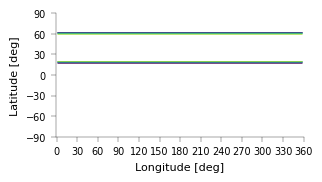

In [7]:
# Show where the land is
save_land_fig = False

job_dir = os.path.join(os.path.dirname(os.environ['GFDL_DATA']), 'jobs')
land_file_name = os.path.join(job_dir, exp_dir, exp_names[0], 'land.nc')
is_land_data = os.path.exists(land_file_name)
if is_land_data:
    fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
    isca_tools.plot.show_land(land_file_name, fig=fig, ax=ax)
    lon_land = isca_tools.utils.land.get_land_coords(land_file=land_file_name)[1]       # get the longitude coordinates of land
    
    if save_fig or save_land_fig:
        fig.savefig(f"/Users/joshduffield/Desktop/land_coords.pdf",
                    dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

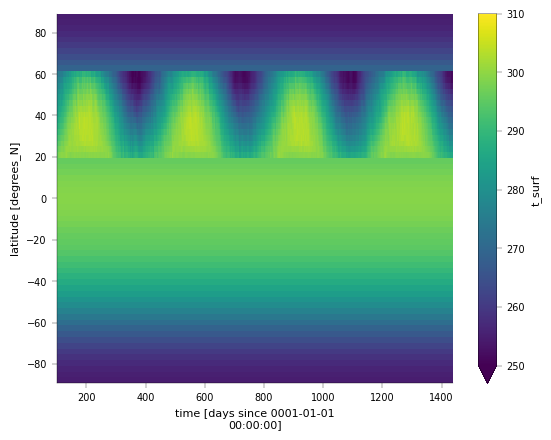

In [8]:
ds[0].t_surf.mean(dim='lon').plot(x='time', vmin=250, vmax=310)

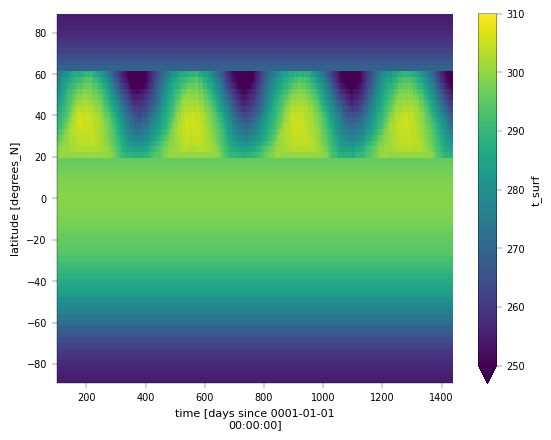

In [9]:
ds[1].t_surf.mean(dim='lon').plot(x='time', vmin=250, vmax=310)

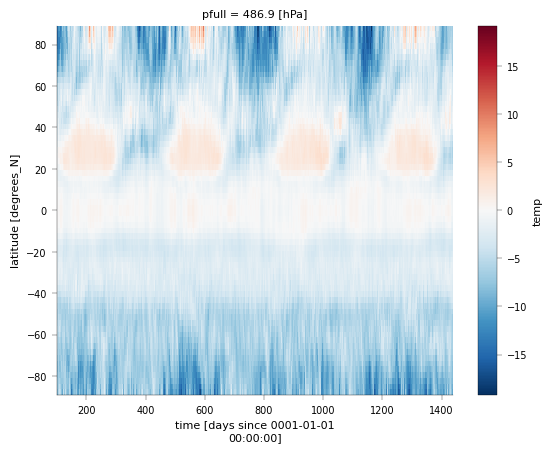

In [10]:
(ds[1].temp.isel(pfull=ind_ft).mean(dim='lon') - ds[0].temp.isel(pfull=ind_ft).mean(dim='lon')).plot(x='time')

(100.0, 1440.0)

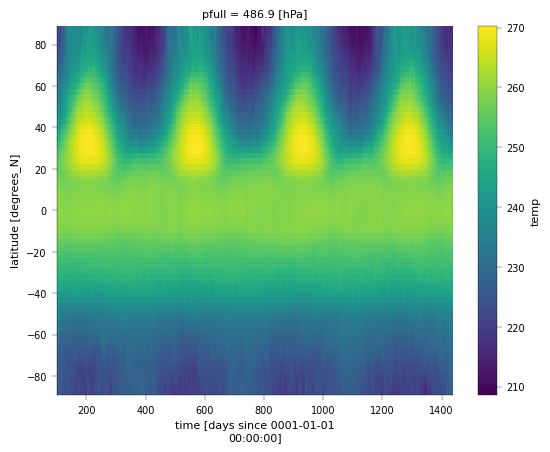

In [11]:
ds[1].temp.isel(pfull=ind_ft).mean(dim='lon').plot(x='time')
plt.xlim()

(-10.0, 50.0)

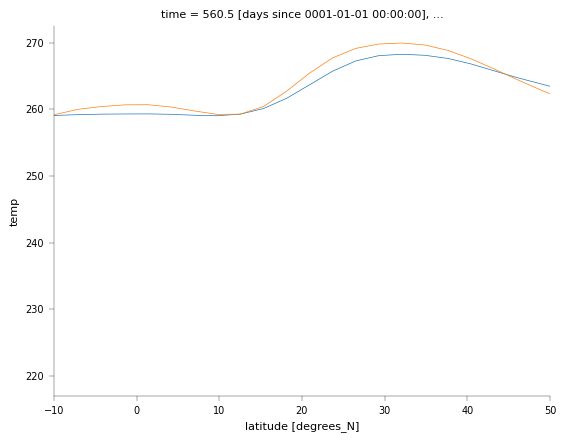

In [12]:
ds[0].temp.isel(pfull=ind_ft).mean(dim='lon').sel(time=560, method='nearest').plot()
ds[1].temp.isel(pfull=ind_ft).mean(dim='lon').sel(time=560, method='nearest').plot()
plt.xlim(-10, 50)

In [13]:
mse = [moist_static_energy(ds[i].temp.isel(pfull=ind_surf), ds[i].sphum.isel(pfull=ind_surf), 0).mean(dim='lon') for i in range(n_exp)]

(-10.0, 50.0)

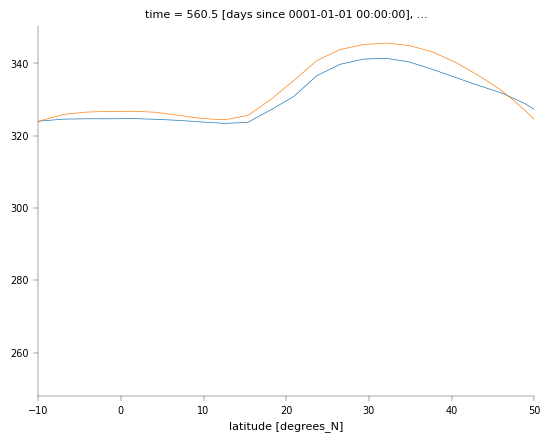

In [14]:
for i in range(n_exp):
    mse[i].sel(time=560, method='nearest').plot()
plt.xlim(-10, 50)

(-10.0, 60.0)

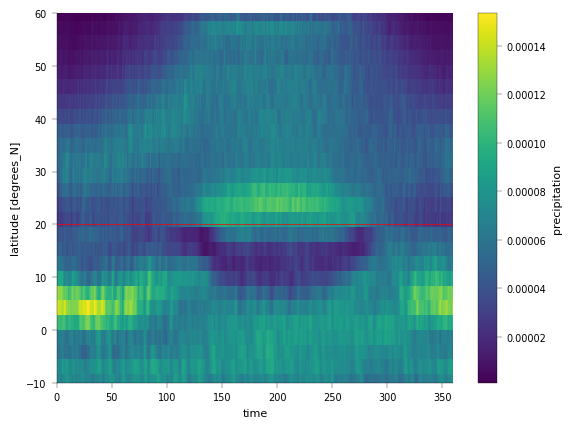

In [15]:
annual_mean(ds[0].precipitation).mean(dim='lon').plot(x='time')
plt.axhline(20, color='r')
plt.ylim(-10, 60)

(-10.0, 60.0)

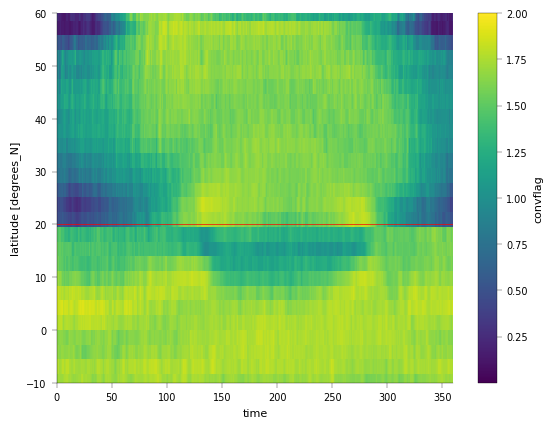

In [16]:
annual_mean(ds[0].convflag).mean(dim='lon').plot(x='time')
plt.axhline(20, color='r')
plt.ylim(-10, 60)

(-10.0, 60.0)

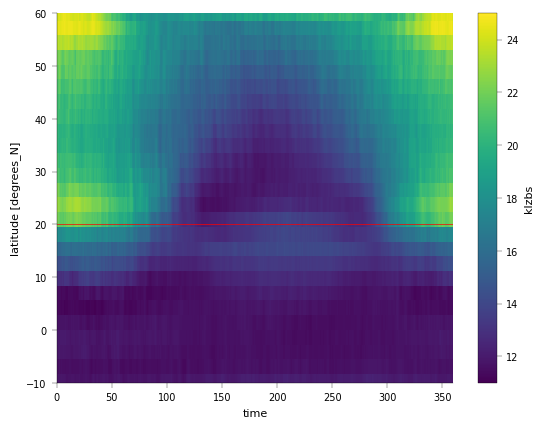

In [21]:
annual_mean(ds[0].klzbs).mean(dim='lon').plot(x='time')
plt.axhline(20, color='r')
plt.ylim(-10, 60)

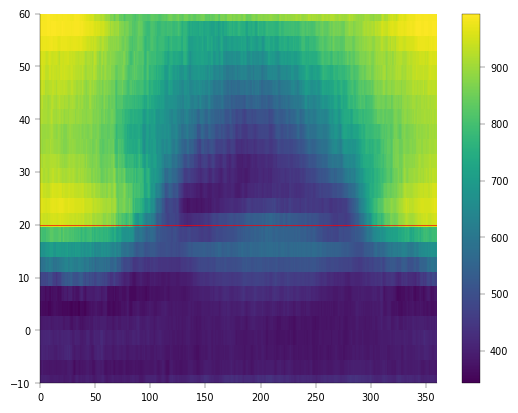

In [32]:
im = plt.pcolormesh(annual_mean(ds[0]).time, ds[0].lat, lzb(annual_mean(ds[0].klzbs).mean(dim='lon')).transpose())
plt.axhline(20, color='r')
plt.ylim(-10, 60)
plt.colorbar(im)

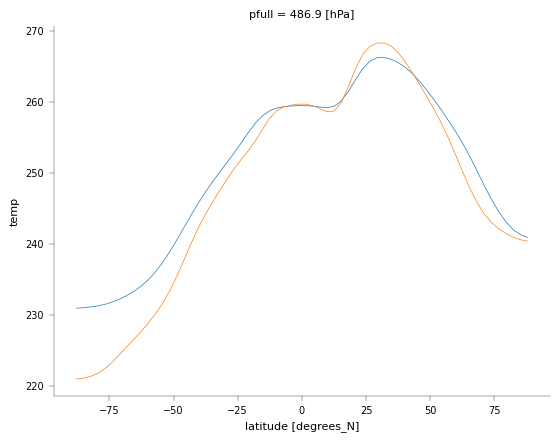

In [47]:
annual_time_slice(ds[0], include_months=[6,7,8]).temp.isel(pfull=ind_ft).mean(dim=['time', 'lon']).plot()
annual_time_slice(ds[1], include_months=[6,7,8]).temp.isel(pfull=ind_ft).mean(dim=['time', 'lon']).plot()